# Qualitative Evaluation of midi2params
Notebook to qualitatively evaluate our trained midi2params model.

In [4]:
# this line basically "injects" the global state of this script
# at the end into this notebook
%run ../midi2params/interact.py
import copy

getting config
getting dataset
loading in dataset fully
getting train
USING AUDIO
train is of length 177
getting val
USING AUDIO
val is of length 18
getting test
USING AUDIO
test is of length 38
making dataloaders
loading model
defining loss function
defining optimizer


### Let's first get our batch and see what's in it. Here you can choose which example we want to look at (with `i`)

In [5]:
for batch in test_loader:
    pass

In [6]:
i = 7
print(batch.keys())

dict_keys(['f0', 'loudness_db', 'conf', 'pitches', 'onset_arr', 'offset_arr', 'audio', 'f0_gt_discrete', 'ld_gt_discrete'])


# First, play the original audio.

In [7]:
from utils.util import preview_audio

audio = to_numpy(batch['audio'][i])[..., np.newaxis]
preview_audio(audio)

Text(0.5, 1.0, 'Audio')

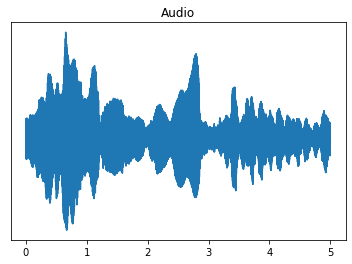

In [9]:
plt.plot(np.linspace(0, 5, audio.flatten().shape[0]), audio.flatten())
plt.yticks([])
plt.title('Audio')

For fun, let's plot a few seconds of the piano roll from the associated MIDI.

Text(0.5, 1.0, 'MIDI Piano Roll')

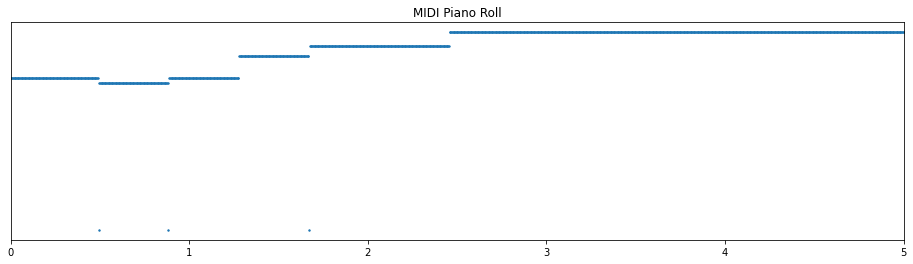

In [10]:
normalize = lambda x: (x - x.min()) / (x.max() - x.min())
plt.figure(figsize=(16, 4))
N = len(batch['pitches'][i][100:])
plt.scatter(np.linspace(0, 5, N), normalize(batch['pitches'][i][100:]), s=2)
plt.xlim(0, 5)
plt.yticks([])
plt.title('MIDI Piano Roll')

# Synthesized from features extracted with DDSP
Now, synthesize with DDSP from the features extracted with DDSP. First, we'll extract the audio parameters and plot them.

/home/poohcom1/midi2params_env/lib/python3.8/site-packages/librosa/core/convert.py:1350: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)
2021-09-04 00:33:24.088441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-04 00:33:24.088490: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-04 00:33:24.088511: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-9E49GT4): /proc/driver/nvidia/version does not exist
2021-09-04 00:33:24.088836: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations,

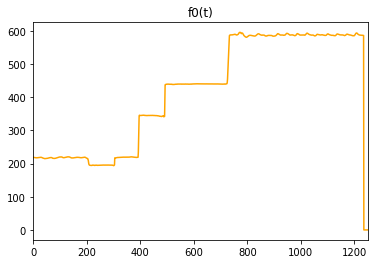

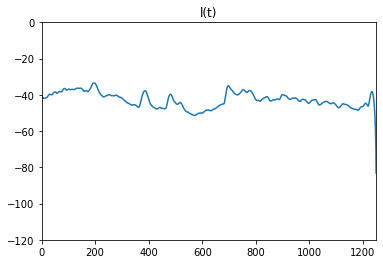

In [11]:
# Extract synthesis parameters

import matplotlib.pyplot as plt

from utils.util import extract_ddsp_synthesis_parameters

audio_parameters = extract_ddsp_synthesis_parameters(audio)

plt.title('f0(t)')
plt.plot(audio_parameters['f0_hz'], color='orange')
plt.xlim(0, 1250)
plt.show()
plt.title('l(t)')
plt.plot(audio_parameters['loudness_db'])
plt.xlim(0, 1250)
plt.ylim(-120, 0)
plt.show()

In [13]:
# Load model

from utils.util import load_ddsp_model

ckpt_path = '../checkpoints/CustomViolinCheckpoint'
model = load_ddsp_model(ckpt_path)

In [14]:
# Resynthesize parameters

from utils.util import synthesize_ddsp_audio

resynth = synthesize_ddsp_audio(model, audio_parameters)

preview_audio(resynth)

# Synthesize with *heuristically generated* features from MIDI
Now, synthesize with DDSP from the features *heuristically generated* from associated MIDI. First, we'll define a couple of functions that will perform the heuristic.

In [15]:
def generate_loud(beats, length=1250, decay=True):
    """
    Generate a loudness envelope for each note, decaying over time.
    """
    arrs = []
    length = 2500
    base = -30
    decay_rate = -0.01 # decays -1 per timestep/index
    #notelength = 0.7
    ld_arr = np.full((length), -120)
    for i, beat in enumerate(beats):
        if i == len(beats) - 1:
            next_beat = length
        else:
            next_beat = beats[i + 1]
        ld_arr[beat:next_beat] = np.linspace(base, base + decay_rate * (next_beat - beat), next_beat - beat)

    return ld_arr


def gen_heuristic(batch, i=0):
    """
    Take a batch containing 'pitches', 'onset_arr', and 'offset_arr' and
    turn them into f0 and loudness heuristically.
    """
    onsets = np.where(batch['onset_arr'][i] == 1)[0]
    if len([i for i in onsets if i < 30]) == 0:
        onsets = np.concatenate(([10], onsets))

    ld = generate_loud(onsets)
    pitches = copy.deepcopy(batch['pitches'][i])
    f0 = p2f(pitches)
    return f0, ld

In [18]:
f0_h, ld_h = gen_heuristic(batch, i=i)

ValueError: operands could not be broadcast together with shapes (1250,) (2500,) 

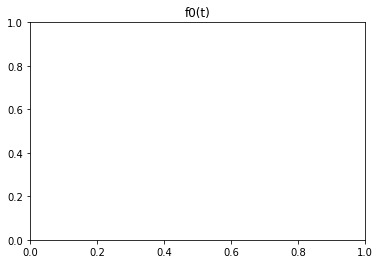

In [19]:
plt.title('f0(t)')
f0_h_sin = np.abs(np.array(f0_h) + 3 * np.sin(np.arange(2500) * .15))
plt.plot(f0_h, color='orange')
plt.plot(f0_h_sin, color='red')
plt.xlim(0, 1250)
plt.show()
plt.title('l(t)')
plt.plot(audio_parameters['loudness_db'], label='loudness (ground truth)')
plt.plot(ld_h, label='loudness (generated)')
plt.ylim(-120, 0)
plt.xlim(0, 1250)
plt.legend()
plt.show()

In [ ]:
torch_f0_h_sin = torch.FloatTensor(f0_h_sin)
heuristic_parameters = {
    'f0_hz': torch_f0_h_sin.type(torch.float32),
    'loudness_db': ld_h.astype(np.float32)
}

In [ ]:
# Resynthesize parameters

heuristic_resynth = synthesize_ddsp_audio(model, heuristic_parameters)

preview_audio(heuristic_resynth)

# Synthesize from feature outputs from *learned model*
Now, synthesize with DDSP from the features generated from the associated MIDI *with our trained model*. First, we define the model path, which is just the path to the saved PyTorch model.

In [20]:
model_path = '../model/best_model.pt'

### Load the model and generate!

In [21]:
for batch in test_loader:
    break

In [25]:
best_model = load_best_model(config, model_path)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [23]:
# converting to CUDA if possible
if config.device == 'cuda':
    for k, arr in batch.items():
        batch[k] = torch.Tensor(arr.float()).cuda()

In [24]:
f0_pred, ld_pred = midi2params(best_model, batch)

NameError: name 'best_model' is not defined

In [ ]:
# now plot with numpy arrays
for k, arr in batch.items():
    batch[k] = to_numpy(arr)

Plotting the outputs...

In [ ]:
print(i)
f0 = batch['f0'][i]
ld = batch['loudness_db'][i]
plt.figure(figsize=(10,5))
plt.title('f0(t) comparison')
plt.plot(f0_pred[i], label='f0 (generated)')
plt.plot(f0, alpha=0.5, label='f0 (ground truth)')
plt.xlim(0, 1250)
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title('l(t)')
plt.plot(ld_pred[i], label='loudness (generated)')
plt.plot(ld, alpha=0.5, label='loudness (ground truth)')
plt.xlim(0, 1250)
plt.ylim(-120, 0)
plt.legend()
plt.show()

In [ ]:
train_params = {
    'f0_hz': f0_pred[i],
    'loudness_db': ld_pred[i]
}

In [ ]:
# Resynthesize parameters

new_model_resynth = synthesize_ddsp_audio(model, train_params)

preview_audio(new_model_resynth)

# Now, all of them side-by-side

## Original Audio

In [ ]:
preview_audio(audio)

## Direct DDSP Features

In [ ]:
preview_audio(resynth)

## Heuristically Generated Features

In [ ]:
preview_audio(heuristic_resynth)

## Features from Trained Model

In [ ]:
preview_audio(new_model_resynth)